In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torchmetrics
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root="../datasets/mnist", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="../datasets/mnist", train=False, transform=transforms.ToTensor())

print("Train set:", len(train_dataset))
print("Test set :", len(test_dataset))

100%|██████████| 9.91M/9.91M [00:11<00:00, 870kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 96.6kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 458kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.14MB/s]

Train set: 60000
Test set : 10000


### Data Preprocessing

In [3]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000], generator=torch.Generator().manual_seed(42))

print("Train set     :", len(train_dataset))
print("Validation set:", len(val_dataset))
print("Test set      :", len(test_dataset))

Train set     : 55000
Validation set: 5000
Test set      : 10000


### Defining the DataLoader

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [5]:
train_counter = Counter()
for _, labels in train_loader:
    train_counter.update(labels.tolist())
print("Training label distribution:")
print(sorted(train_counter.items()))
 
val_counter = Counter()
for _, labels in val_loader:
    val_counter.update(labels.tolist())
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    
test_counter = Counter()
for _, labels in test_loader:
    test_counter.update(labels.tolist())
print("\nTest label distribution:")
print(sorted(test_counter.items()))

Training label distribution:
[(0, 5441), (1, 6190), (2, 5477), (3, 5600), (4, 5346), (5, 5000), (6, 5422), (7, 5710), (8, 5347), (9, 5467)]

Validation label distribution:
[(0, 482), (1, 552), (2, 481), (3, 531), (4, 496), (5, 421), (6, 496), (7, 555), (8, 504), (9, 482)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### Visualizing the dataset

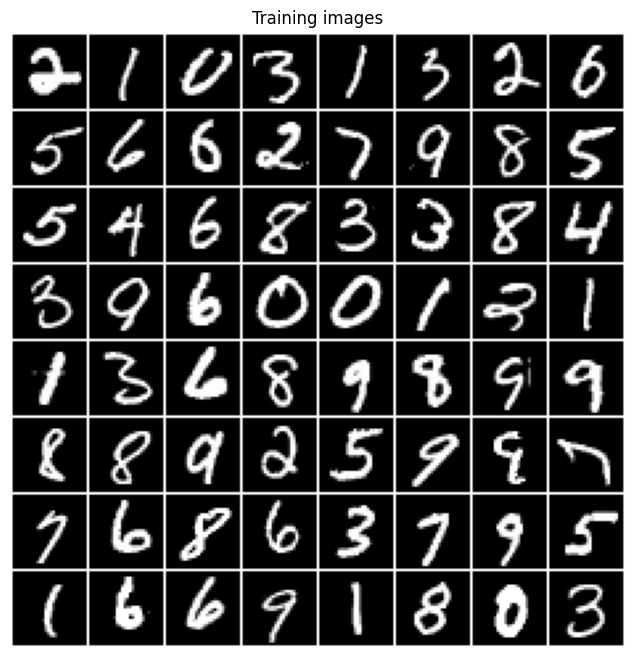

In [6]:
import torchvision

for images, _ in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(
    torchvision.utils.make_grid(
        images[:64], 
        padding=1,
        pad_value=1.0,
        normalize=True),
        (1, 2, 0)))
plt.show()

### Zero-Rule baseline (majority class classifier)

In [7]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f}")

Majority class: 1
Accuracy when always predicting the majority class: 0.11


### Design the Model

In [8]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

### Train the model

In [9]:
def predict(model, X):
    model = model.eval()
    with torch.inference_mode():
            return model(X)
        
def compute_accuracy(model, dataloader):
    correct = 0
    total_samples = 0  
    for _, (X_batch, y_batch) in enumerate(dataloader):
        logits = predict(model, X_batch)
        y_preds = torch.argmax(logits, dim=1)
        compare = y_batch == y_preds
        correct += torch.sum(compare)
        total_samples += len(compare)
    return correct / total_samples

In [10]:
loss_list = []    
val_acc_list = []
train_acc_list = []

def train(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model = model.train()        
        for batch_idx, (features, labels) in enumerate(train_loader):
            # forward pass
            logits = model(features)
            loss = F.cross_entropy(logits, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
            
            if not batch_idx % 250:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
                    f' | batch {batch_idx+1:03d}/{len(train_loader):03d}'
                    f' | train_loss: {loss:.2f}')
            loss_list.append(loss.item())
            
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"train_acc: {train_acc:.2f} | val_acc: {val_acc:.2f}")


num_epochs = 10    
model = PyTorchMLP(num_features=784, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Stochastic gradient descent
train(model, optimizer, num_epochs)

Epoch: 001/010 | batch 001/860 | train_loss: 2.31
Epoch: 001/010 | batch 251/860 | train_loss: 0.81
Epoch: 001/010 | batch 501/860 | train_loss: 0.50
Epoch: 001/010 | batch 751/860 | train_loss: 0.49
train_acc: 0.89 | val_acc: 0.89
Epoch: 002/010 | batch 001/860 | train_loss: 0.31
Epoch: 002/010 | batch 251/860 | train_loss: 0.25
Epoch: 002/010 | batch 501/860 | train_loss: 0.25
Epoch: 002/010 | batch 751/860 | train_loss: 0.20
train_acc: 0.92 | val_acc: 0.91
Epoch: 003/010 | batch 001/860 | train_loss: 0.14
Epoch: 003/010 | batch 251/860 | train_loss: 0.36
Epoch: 003/010 | batch 501/860 | train_loss: 0.24
Epoch: 003/010 | batch 751/860 | train_loss: 0.22
train_acc: 0.94 | val_acc: 0.93
Epoch: 004/010 | batch 001/860 | train_loss: 0.18
Epoch: 004/010 | batch 251/860 | train_loss: 0.20
Epoch: 004/010 | batch 501/860 | train_loss: 0.19
Epoch: 004/010 | batch 751/860 | train_loss: 0.21
train_acc: 0.95 | val_acc: 0.94
Epoch: 005/010 | batch 001/860 | train_loss: 0.20
Epoch: 005/010 | batch

### Save and Load the Model

In [11]:
# save the model
# MODEL_PATH = "pytorch.pt"
# torch.save(pytorch_model.state_dict(), MODEL_PATH)

# load the model
# model = PyTorchMLP(num_features=784, num_classes=10)
# model.load_state_dict(torch.load(MODEL_PATH))
# model.eval()

### Evaluate the Model

In [12]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Val Accuracy  : {val_acc:.2f}")
print(f"Test Accuracy : {test_acc:.2f}")

Train Accuracy: 0.97
Val Accuracy  : 0.96
Test Accuracy : 0.97


### Vizualize Confusion Matrix

In [13]:
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

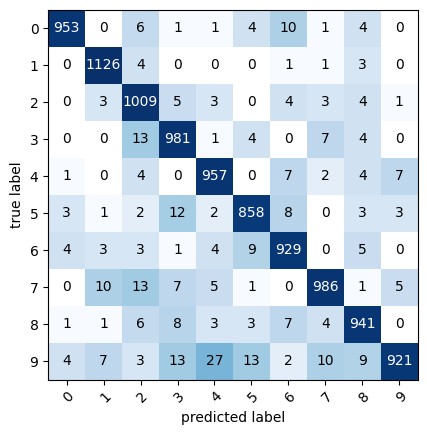

In [14]:
import matplotlib
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in test_loader:
    with torch.inference_mode():
        pred = model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()
fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Vizualize Training Metrices

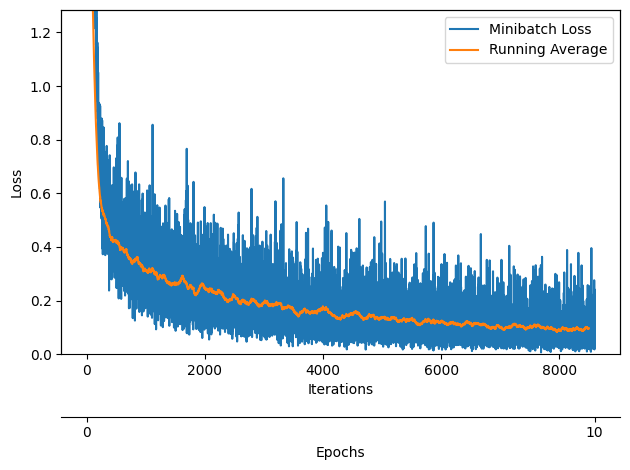

In [15]:
from modules.plotting_helper import plot_training_loss
plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

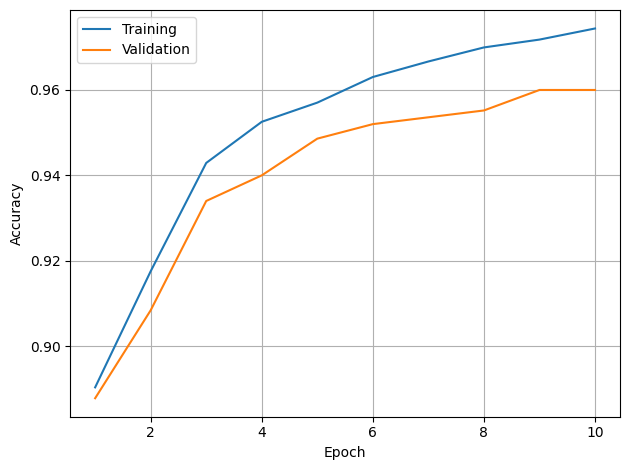

In [16]:
from modules.plotting_helper import plot_accuracy
plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)

### Visualizing the Results

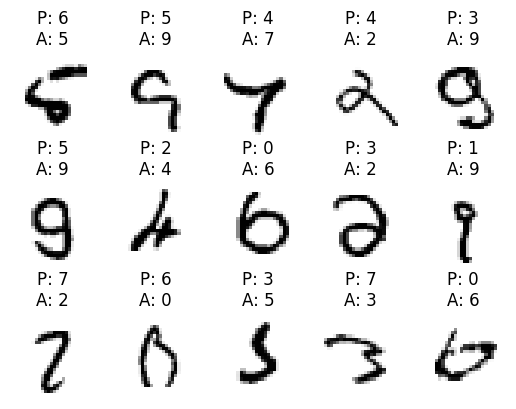

In [17]:
from modules.plotting_helper import show_failures
failures = show_failures(model=model, data_loader=test_loader, class_dict=class_dict)
# plt.savefig('failures.pdf')